In [44]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt


In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [45]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    r"C:\Cotton plant disease detection",
    batch_size=BATCH_SIZE,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    shuffle=True,
    
)

Found 1815 files belonging to 5 classes.


In [46]:
class_names=dataset.class_names
print(class_names)



['Aphids', 'Bacterial Blight', 'Powdery Mildew', 'Target spot', 'healthy leaf']


# Data visuallization

(32, 256, 256, 3)
[4 4 0 4 4 0 4 1 2 4 3 0 0 1 4 4 3 1 2 1 4 4 1 4 4 4 1 0 0 2 4 3]


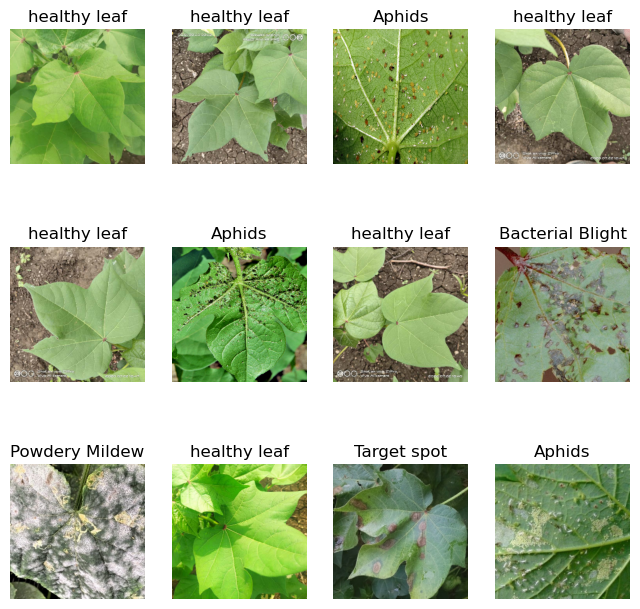

In [5]:
plt.figure(figsize=(8,8))
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[labels_batch[i]])
        plt.axis('off')

In [47]:
Training : 80 
Validation: 10 
Test: 10 


In [48]:
train_size=0.8
len(dataset)*train_size


45.6

In [8]:
train_ds=dataset.take(45)
len(train_ds)

45

In [9]:
test_ds=dataset.skip(45)
len(test_ds)


12

In [10]:
val_size =0.1
len(dataset)*val_size

5.7

In [11]:
val_ds=test_ds.take(5)
len(val_ds)

5

In [12]:
test_ds=test_ds.skip(5)
len(test_ds)

7

In [13]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [14]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [15]:
len(train_ds)

45

In [16]:
len(val_ds)

5

In [17]:
len(test_ds)


7

# Cache, Shuffle, and Prefetch the Dataset


In [18]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [19]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch[0].numpy()/255)

[[[0.3816789  0.4870518  0.2885802 ]
  [0.3745822  0.48046455 0.27483425]
  [0.38052237 0.48640472 0.28383118]
  ...
  [0.9110907  0.90324754 0.9542279 ]
  [0.9137255  0.90588236 0.95686275]
  [0.91501224 0.9071691  0.9581495 ]]

 [[0.36552542 0.46730238 0.2831725 ]
  [0.36072305 0.46268383 0.2761823 ]
  [0.37261796 0.47457874 0.29038757]
  ...
  [0.90588236 0.8980392  0.9490196 ]
  [0.9098039  0.9019608  0.9529412 ]
  [0.9136761  0.90583295 0.95681334]]

 [[0.36862746 0.45882353 0.28345588]
  [0.36077258 0.46028084 0.28462777]
  [0.36329657 0.46133578 0.29961535]
  ...
  [0.90583557 0.89799243 0.9489728 ]
  [0.90839463 0.9005515  0.9515319 ]
  [0.9102897  0.90244657 0.95342696]]

 ...

 [[0.21730885 0.30358335 0.15064219]
  [0.23853964 0.32481414 0.17187296]
  [0.25503218 0.3413067  0.19228707]
  ...
  [0.33082107 0.42101717 0.25631127]
  [0.33706546 0.42726153 0.26255566]
  [0.3460216  0.43621767 0.2715118 ]]

 [[0.22105126 0.30732578 0.1543846 ]
  [0.23239124 0.31866574 0.16572458]


# Build model 

In [20]:
#Creating a Layer for Resizing and Normalization
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1.0/255),
])

#  Data Augmentation

In [21]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [22]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [23]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 5

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)


# 
Compiling the Model
We use adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric

In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [25]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [26]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)


Epoch 1/50


45/45 [==============================] - 65s 1s/step - loss: 1.4564 - accuracy: 0.3864 - val_loss: 1.2446 - val_accuracy: 0.4375
Epoch 2/50
45/45 [==============================] - 43s 947ms/step - loss: 1.1107 - accuracy: 0.5332 - val_loss: 0.8934 - val_accuracy: 0.6438
Epoch 3/50
45/45 [==============================] - 43s 947ms/step - loss: 1.0369 - accuracy: 0.5779 - val_loss: 0.8177 - val_accuracy: 0.6750
Epoch 4/50
45/45 [==============================] - 44s 978ms/step - loss: 0.8063 - accuracy: 0.6883 - val_loss: 1.0686 - val_accuracy: 0.5437
Epoch 5/50
45/45 [==============================] - 44s 976ms/step - loss: 0.6997 - accuracy: 0.7414 - val_loss: 0.9776 - val_accuracy: 0.6062
Epoch 6/50
45/45 [==============================] - 44s 975ms/step - loss: 0.6898 - accuracy: 0.7296 - val_loss: 0.6414 - val_accuracy: 0.8000
Epoch 7/50
45/45 [==============================] - 44s 970ms/step - loss: 0.5313 - accuracy: 0.8043 - val_loss: 0.5899 - val_accuracy: 0.8125


In [27]:
scores = model.evaluate(test_ds)

7/7 [==============================] - 8s 212ms/step - loss: 0.2950 - accuracy: 0.9241


In [28]:
scores

[0.29498645663261414, 0.9241071343421936]

In [29]:
history

In [30]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 45}

In [31]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [32]:
type(history.history['loss'])

list

In [33]:

len(history.history['loss'])

50

In [34]:
history.history['loss'][:5] # show loss for first 5 epochs

[1.456393837928772,
 1.110713243484497,
 1.0369021892547607,
 0.8063397407531738,
 0.6997066736221313]

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

1/1 [==============================] - 0s 298ms/step


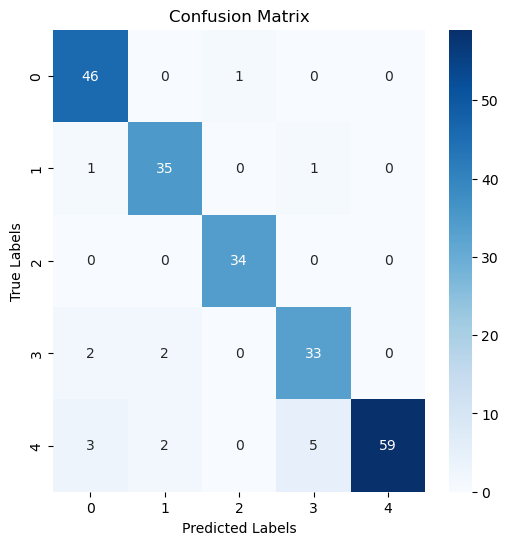

In [36]:

from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Extract true labels from the test dataset
true_labels = []
predicted_labels = []

for images, labels in test_ds:
    true_labels.extend(labels.numpy())
    predictions = model.predict(images)
    predicted_labels.extend(np.argmax(predictions, axis=1))

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix with colored formatting
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


#  Model Evaluation


first image to predict
actual label: Target spot
1/1 [==============================] - 0s 315ms/step
predicted label: Target spot


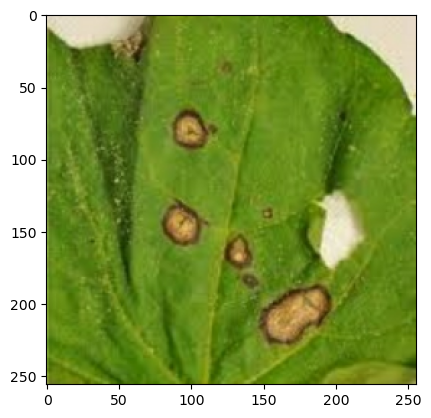

In [37]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
# Assuming you have already trained and saved your model
from tensorflow.keras.models import load_model

# Load your trained model
model = load_model(r"C:\cotton disease plant model\new_model.h5")

1/1 [==============================] - 0s 467ms/step
Predicted label: powdery Mildew


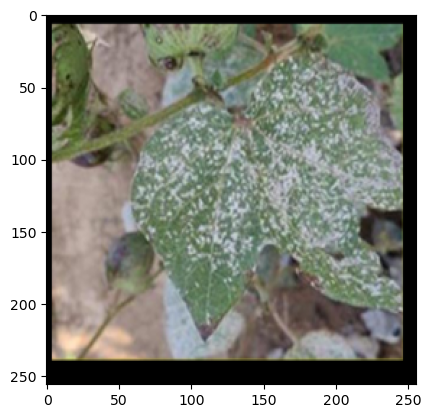

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.models import load_model

# Load your trained model
model = load_model(r"C:\cotton disease plant model\new_model.h5")

# Define your class names (if applicable)
# Replace this with your actual class names used during training
class_names = ['Aphids','powdery Mildew', 'Target spot', 'Bacterial Blight', 'healthy leaf']  # Example class names

# Load and preprocess your unseen PNG image
unseen_image = r"C:\Users\jades\Downloads\cotton plant.png"
unseen_image = Image.open(unseen_image)
unseen_image = unseen_image.convert('RGB')  # Convert image to RGB format
unseen_image = unseen_image.resize((256, 256))  # Resize to match your model input size
unseen_image = np.array(unseen_image)  # Convert to numpy array
unseen_image = unseen_image / 255.0  # Normalize pixel values (assuming your model expects normalized input)


# Add batch dimension
unseen_image = np.expand_dims(unseen_image, axis=0)

# Make predictions
predictions = model.predict(unseen_image)

# Display prediction (if class_names are provided)
if class_names:
    predicted_label = class_names[np.argmax(predictions[0])]
    print("Predicted label:", predicted_label)

# Display the unseen image
plt.imshow(unseen_image[0])
plt.show()


# Write a function for inference

In [42]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

# Now run inference on few sample images

In [ ]:
plt.figure(figsize=(10, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")


# Saving the Model

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten



# Save the model as HDF5 format
h5_model_path = r"C:\cotton disease plant model\new_model.h5"
model.save(h5_model_path)

In [ ]:
# in pb version

In [ ]:
import os
os.listdir(r"C:\cotton disease disease H5\saved model")

In [ ]:

[int(i) for i in (os.listdir(r"C:\cotton disease disease H5\saved model")+[0])]

In [ ]:
model_version = 1
model.save(r'C:\cotton disease disease H5\saved model\model_version')

In [43]:
from sklearn.metrics import classification_report
import numpy as np

# Define class names based on your dataset structure
class_names = ['Aphids', 'Bacterial Blight', 'Powdery Mildew', 'Target spot', 'healthy leaf'] 

# Extract true labels from the test dataset
true_labels = []
for images, labels in test_ds:
    true_labels.extend(labels.numpy())

# Predict labels for the test dataset
predicted_labels = []
for images, _ in test_ds:
    predictions = model.predict(images)
    predicted_labels.extend(np.argmax(predictions, axis=1))

# Generate classification report
print('Classification Report:')
print(classification_report(true_labels, predicted_labels, target_names=class_names))


1/1 [==============================] - 0s 308ms/step
Classification Report:
                  precision    recall  f1-score   support

          Aphids       0.11      0.13      0.12        47
Bacterial Blight       0.09      0.08      0.08        37
  Powdery Mildew       0.15      0.15      0.15        34
     Target spot       0.12      0.11      0.12        37
    healthy leaf       0.20      0.20      0.20        69

        accuracy                           0.14       224
       macro avg       0.13      0.13      0.13       224
    weighted avg       0.14      0.14      0.14       224

